手工搭建完整Transformer模型
测试Transformer组件...
输入形状: src=torch.Size([2, 10]), tgt=torch.Size([2, 10])

1. 测试位置编码...
位置编码输出形状: torch.Size([10, 2, 128])

2. 测试多头注意力...
多头注意力输出形状: torch.Size([2, 10, 128])
注意力权重形状: torch.Size([2, 8, 10, 10])

3. 测试编码器层...
编码器层输出形状: torch.Size([2, 10, 128])

4. 测试解码器层...
解码器层输出形状: torch.Size([2, 10, 128])

5. 测试完整模型...
模型输出形状: torch.Size([2, 9, 100])
模型参数量: 964,708

2. 训练完整Transformer模型...
开始训练...
Epoch 1/10 | Train Loss: 4.4637 | Val Loss: 4.3902 | Train PPL: 86.80 | Val PPL: 80.66 | Time: 1.17s
Epoch 2/10 | Train Loss: 4.2258 | Val Loss: 4.1901 | Train PPL: 68.43 | Val PPL: 66.03 | Time: 1.08s
Epoch 3/10 | Train Loss: 4.0129 | Val Loss: 4.0813 | Train PPL: 55.31 | Val PPL: 59.22 | Time: 1.10s
Epoch 4/10 | Train Loss: 3.4975 | Val Loss: 3.2563 | Train PPL: 33.03 | Val PPL: 25.95 | Time: 1.06s
Epoch 5/10 | Train Loss: 2.4949 | Val Loss: 2.0806 | Train PPL: 12.12 | Val PPL: 8.01 | Time: 1.12s
Epoch 6/10 | Train Loss: 1.5223 | Val Loss: 1.1710 | Train PPL: 4.58 | Val

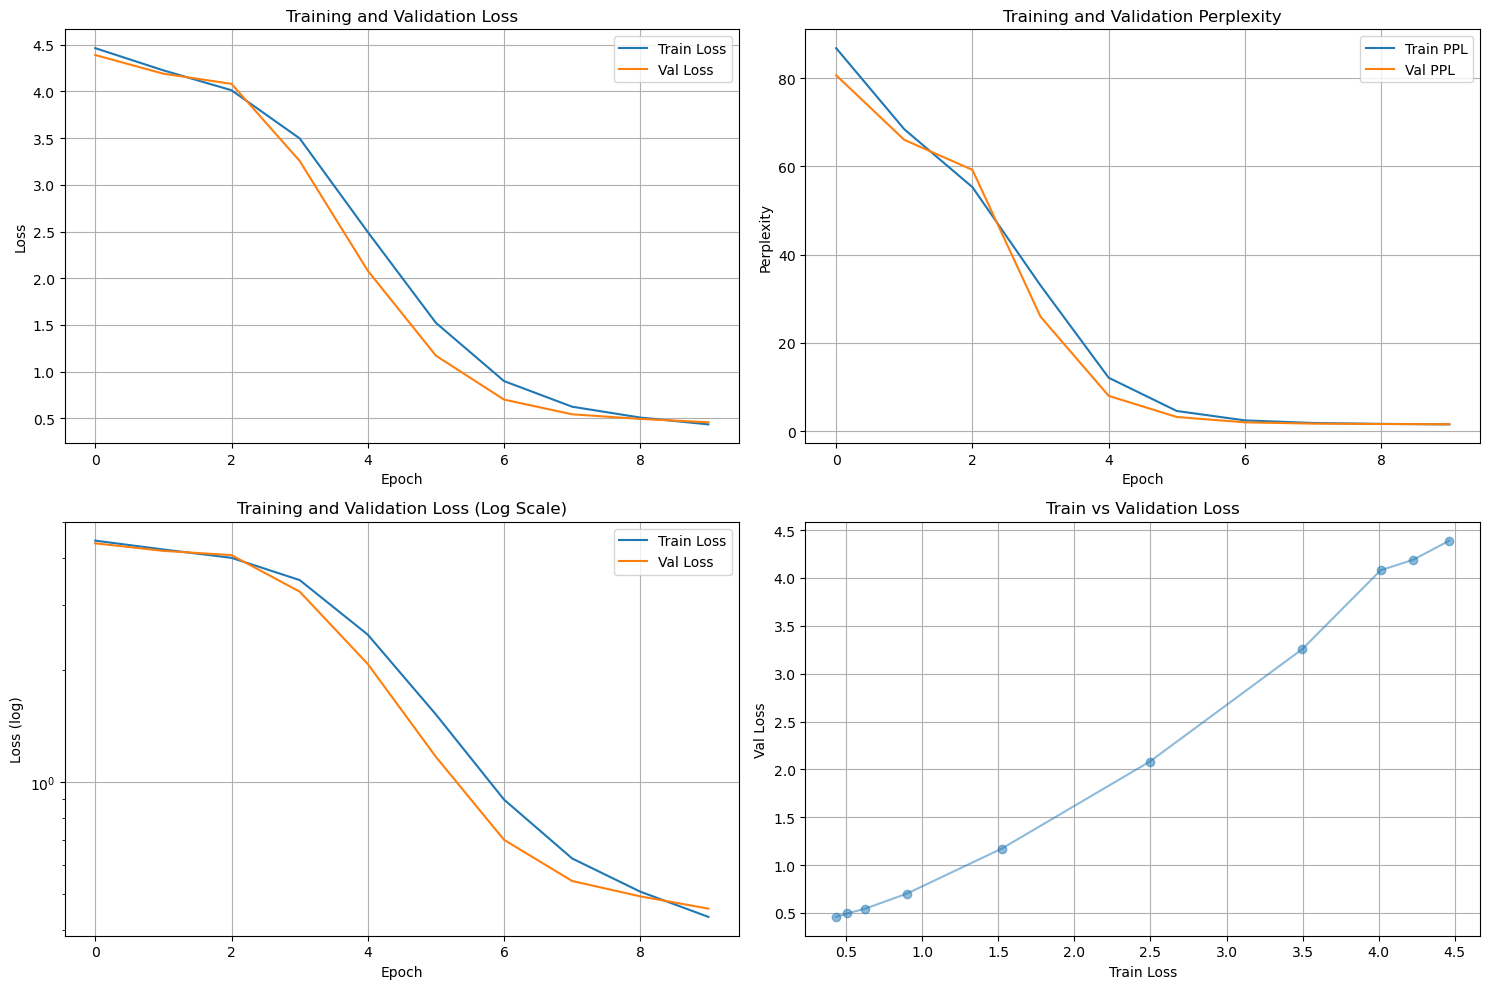


4. 进行消融实验...

进行消融实验...

训练变体: baseline
开始训练...
Epoch 1/5 | Train Loss: 4.4817 | Val Loss: 4.4447 | Train PPL: 88.38 | Val PPL: 85.17 | Time: 0.95s
Epoch 2/5 | Train Loss: 4.3551 | Val Loss: 4.3245 | Train PPL: 77.88 | Val PPL: 75.53 | Time: 0.97s
Epoch 3/5 | Train Loss: 4.1522 | Val Loss: 4.2082 | Train PPL: 63.57 | Val PPL: 67.23 | Time: 0.98s
Epoch 4/5 | Train Loss: 3.9172 | Val Loss: 3.9823 | Train PPL: 50.26 | Val PPL: 53.64 | Time: 0.95s
Epoch 5/5 | Train Loss: 3.4773 | Val Loss: 3.3551 | Train PPL: 32.37 | Val PPL: 28.65 | Time: 0.90s

训练变体: no_positional_encoding
开始训练...
Epoch 1/5 | Train Loss: 4.4537 | Val Loss: 4.3861 | Train PPL: 85.94 | Val PPL: 80.33 | Time: 0.91s
Epoch 2/5 | Train Loss: 4.1697 | Val Loss: 4.2154 | Train PPL: 64.70 | Val PPL: 67.72 | Time: 0.88s
Epoch 3/5 | Train Loss: 3.8882 | Val Loss: 3.9946 | Train PPL: 48.82 | Val PPL: 54.30 | Time: 0.92s
Epoch 4/5 | Train Loss: 3.5003 | Val Loss: 3.4996 | Train PPL: 33.13 | Val PPL: 33.10 | Time: 0.90s
Epoch 5/5 | T

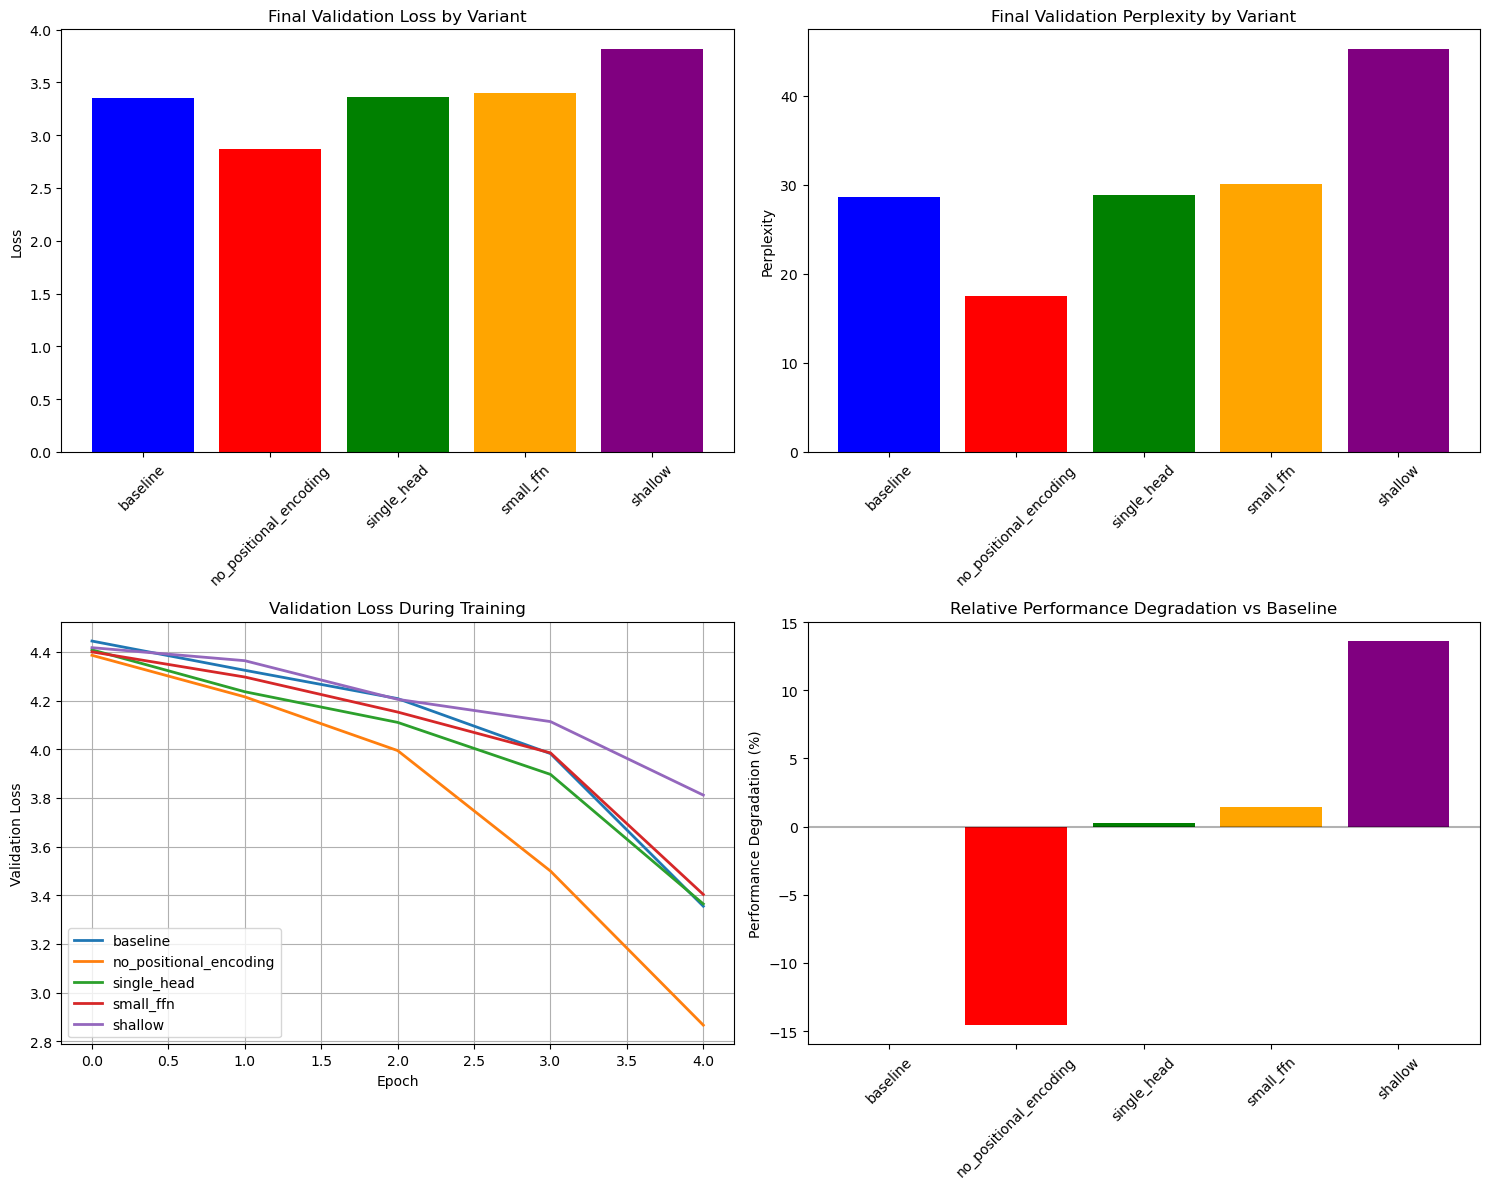


消融实验详细结果:
--------------------------------------------------------------------------------
Variant                   Val Loss   Val PPL    Degradation (%)
--------------------------------------------------------------------------------
baseline                  3.3551     28.65      0.00           
no_positional_encoding    2.8664     17.57      -14.57         
single_head               3.3645     28.92      0.28           
small_ffn                 3.4034     30.07      1.44           
shallow                   3.8116     45.22      13.61          

实验完成！


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict, List
import time
from torch.utils.data import Dataset, DataLoader

# 设置随机种子保证可重现性
torch.manual_seed(42)
np.random.seed(42)

class PositionalEncoding(nn.Module):
    """正弦位置编码"""
    
    def __init__(self, d_model: int, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(0), :]

class MultiHeadAttention(nn.Module):
    """多头注意力机制"""
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model必须能被num_heads整除"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, q: torch.Tensor, k: torch.Tensor, 
                                   v: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # 计算注意力分数
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 应用掩码
        if mask is not None:
            # 确保掩码形状正确 [batch_size, num_heads, seq_len_q, seq_len_k]
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)
            elif mask.dim() == 3:
                mask = mask.unsqueeze(1)
            
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        output = torch.matmul(attn_weights, v)
        
        return output, attn_weights
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
                mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size = query.size(0)
        
        # 线性变换并分头
        Q = self.w_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 应用缩放点积注意力
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并多头
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)
        
        # 最终线性变换
        output = self.w_o(attn_output)
        
        return output, attn_weights

class PositionWiseFFN(nn.Module):
    """位置前馈网络"""
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFFN, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

class ResidualConnection(nn.Module):
    """残差连接和层归一化"""
    
    def __init__(self, d_model: int, dropout: float = 0.1):
        super(ResidualConnection, self).__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, sublayer: nn.Module) -> torch.Tensor:
        return x + self.dropout(sublayer(self.layer_norm(x)))

class TransformerEncoderLayer(nn.Module):
    """Transformer编码器层"""
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFFN(d_model, d_ff, dropout)
        self.residual1 = ResidualConnection(d_model, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.residual1(x, lambda x: self.self_attention(x, x, x, mask)[0])
        x = self.residual2(x, self.feed_forward)
        return x

class TransformerDecoderLayer(nn.Module):
    """Transformer解码器层"""
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFFN(d_model, d_ff, dropout)
        
        self.residual1 = ResidualConnection(d_model, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)
        self.residual3 = ResidualConnection(d_model, dropout)
        
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, 
                self_attention_mask: Optional[torch.Tensor] = None,
                cross_attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # 掩码自注意力
        x = self.residual1(x, lambda x: self.self_attention(x, x, x, self_attention_mask)[0])
        # 交叉注意力（使用编码器输出）
        x = self.residual2(x, lambda x: self.cross_attention(x, encoder_output, encoder_output, cross_attention_mask)[0])
        # 前馈网络
        x = self.residual3(x, self.feed_forward)
        return x

class Transformer(nn.Module):
    """完整的Transformer模型（编码器-解码器）"""
    
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, d_model: int, num_heads: int, 
                 d_ff: int, num_encoder_layers: int, num_decoder_layers: int, 
                 max_seq_len: int, dropout: float = 0.1):
        super(Transformer, self).__init__()
        self.d_model = d_model
        
        # 源语言和目标语言的词嵌入
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        # 位置编码
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)
        
        # 编码器
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        self.encoder_norm = nn.LayerNorm(d_model)
        
        # 解码器
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])
        self.decoder_norm = nn.LayerNorm(d_model)
        
        # 输出层
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        # 权重初始化
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
    
    def encode(self, src_tokens: torch.Tensor, src_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # 源语言嵌入 + 位置编码
        x = self.src_embedding(src_tokens) * math.sqrt(self.d_model)
        x = self.positional_encoding(x.transpose(0, 1)).transpose(0, 1)
        
        # 编码器层
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        
        return self.encoder_norm(x)
    
    def decode(self, tgt_tokens: torch.Tensor, encoder_output: torch.Tensor,
               tgt_mask: Optional[torch.Tensor] = None, 
               memory_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # 目标语言嵌入 + 位置编码
        x = self.tgt_embedding(tgt_tokens) * math.sqrt(self.d_model)
        x = self.positional_encoding(x.transpose(0, 1)).transpose(0, 1)
        
        # 解码器层
        for layer in self.decoder_layers:
            x = layer(x, encoder_output, tgt_mask, memory_mask)
        
        return self.decoder_norm(x)
    
    def forward(self, src_tokens: torch.Tensor, tgt_tokens: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None,
                memory_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        encoder_output = self.encode(src_tokens, src_mask)
        decoder_output = self.decode(tgt_tokens, encoder_output, tgt_mask, memory_mask)
        logits = self.output_projection(decoder_output)
        return logits

def create_padding_mask(seq: torch.Tensor, pad_idx: int = 0) -> torch.Tensor:
    """创建padding掩码"""
    mask = (seq != pad_idx).unsqueeze(1).unsqueeze(2)
    return mask

def create_look_ahead_mask(seq_len: int) -> torch.Tensor:
    """创建look-ahead掩码（用于解码器自注意力）"""
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

class TinyTranslationDataset(Dataset):
    """小型翻译数据集（用于演示）"""
    
    def __init__(self, num_samples=1000, src_vocab_size=100, tgt_vocab_size=100, max_len=20):
        self.num_samples = num_samples
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.max_len = max_len
        
        # 生成随机翻译数据
        self.src_data = torch.randint(1, src_vocab_size-1, (num_samples, max_len))
        self.tgt_data = torch.randint(1, tgt_vocab_size-1, (num_samples, max_len))
        
        # 添加开始和结束标记
        self.src_data[:, 0] = 0  # 开始标记
        self.tgt_data[:, 0] = 0  # 开始标记
        for i in range(num_samples):
            # 随机长度
            src_len = torch.randint(5, max_len-1, (1,))
            tgt_len = torch.randint(5, max_len-1, (1,))
            
            self.src_data[i, src_len:] = src_vocab_size - 1  # 填充
            self.tgt_data[i, tgt_len:] = tgt_vocab_size - 1  # 填充
            
            # 结束标记
            self.src_data[i, src_len-1] = src_vocab_size - 2
            self.tgt_data[i, tgt_len-1] = tgt_vocab_size - 2
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return {
            'src': self.src_data[idx],
            'tgt': self.tgt_data[idx]
        }

class Trainer:
    """训练器类"""
    
    def __init__(self, model, train_loader, val_loader, learning_rate=0.001):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
        self.criterion = nn.CrossEntropyLoss(ignore_index=model.tgt_embedding.num_embeddings - 1)
        
        self.train_losses = []
        self.val_losses = []
        self.train_ppl = []
        self.val_ppl = []
    
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        
        for batch in self.train_loader:
            src = batch['src']
            tgt = batch['tgt']
            
            # 创建掩码
            src_mask = create_padding_mask(src)
            tgt_mask = create_padding_mask(tgt)
            
            # 前向传播
            self.optimizer.zero_grad()
            
            # 解码器输入（去掉最后一个token）
            decoder_input = tgt[:, :-1]
            # 目标输出（去掉第一个token）
            target = tgt[:, 1:]
            
            # 创建look-ahead掩码
            look_ahead_mask = create_look_ahead_mask(decoder_input.size(1))
            # 扩展维度以匹配多头注意力的形状
            look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, seq_len, seq_len]
            
            # 组合padding mask和look-ahead mask
            tgt_padding_mask = tgt_mask[:, :, :, :decoder_input.size(1)].squeeze(1)  # [batch, 1, seq_len]
            combined_mask = look_ahead_mask & tgt_padding_mask.unsqueeze(-1)
            
            output = self.model(src, decoder_input, src_mask, combined_mask)
            
            loss = self.criterion(output.reshape(-1, output.size(-1)), target.reshape(-1))
            
            # 反向传播
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in self.val_loader:
                src = batch['src']
                tgt = batch['tgt']
                
                src_mask = create_padding_mask(src)
                tgt_mask = create_padding_mask(tgt)
                
                decoder_input = tgt[:, :-1]
                target = tgt[:, 1:]
                
                look_ahead_mask = create_look_ahead_mask(decoder_input.size(1))
                look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)
                tgt_padding_mask = tgt_mask[:, :, :, :decoder_input.size(1)].squeeze(1)
                combined_mask = look_ahead_mask & tgt_padding_mask.unsqueeze(-1)
                
                output = self.model(src, decoder_input, src_mask, combined_mask)
                
                loss = self.criterion(output.reshape(-1, output.size(-1)), target.reshape(-1))
                total_loss += loss.item()
        
        return total_loss / len(self.val_loader)
    
    def train(self, num_epochs):
        print("开始训练...")
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            train_loss = self.train_epoch()
            val_loss = self.validate()
            
            train_ppl = math.exp(min(train_loss, 10))  # 防止数值溢出
            val_ppl = math.exp(min(val_loss, 10))
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_ppl.append(train_ppl)
            self.val_ppl.append(val_ppl)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs} | '
                  f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
                  f'Train PPL: {train_ppl:.2f} | Val PPL: {val_ppl:.2f} | '
                  f'Time: {epoch_time:.2f}s')
    
    def plot_training_curves(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # 损失曲线
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # 困惑度曲线
        ax2.plot(self.train_ppl, label='Train PPL')
        ax2.plot(self.val_ppl, label='Val PPL')
        ax2.set_title('Training and Validation Perplexity')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Perplexity')
        ax2.legend()
        ax2.grid(True)
        
        # 损失对数曲线
        ax3.semilogy(self.train_losses, label='Train Loss')
        ax3.semilogy(self.val_losses, label='Val Loss')
        ax3.set_title('Training and Validation Loss (Log Scale)')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss (log)')
        ax3.legend()
        ax3.grid(True)
        
        # 学习曲线对比
        ax4.plot(self.train_losses, self.val_losses, 'o-', alpha=0.5)
        ax4.set_xlabel('Train Loss')
        ax4.set_ylabel('Val Loss')
        ax4.set_title('Train vs Validation Loss')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def test_transformer_components():
    """测试Transformer组件"""
    print("测试Transformer组件...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 128
    num_heads = 8
    d_ff = 512
    src_vocab_size = 100
    tgt_vocab_size = 100
    
    # 创建测试数据
    src = torch.randint(0, src_vocab_size, (batch_size, seq_len))
    tgt = torch.randint(0, tgt_vocab_size, (batch_size, seq_len))
    
    print(f"输入形状: src={src.shape}, tgt={tgt.shape}")
    
    # 测试位置编码
    print("\n1. 测试位置编码...")
    pos_enc = PositionalEncoding(d_model)
    dummy_embedding = torch.randn(seq_len, batch_size, d_model)
    output_pos = pos_enc(dummy_embedding)
    print(f"位置编码输出形状: {output_pos.shape}")
    
    # 测试多头注意力
    print("\n2. 测试多头注意力...")
    mha = MultiHeadAttention(d_model, num_heads)
    dummy_input = torch.randn(batch_size, seq_len, d_model)
    attn_output, attn_weights = mha(dummy_input, dummy_input, dummy_input)
    print(f"多头注意力输出形状: {attn_output.shape}")
    print(f"注意力权重形状: {attn_weights.shape}")
    
    # 测试编码器层
    print("\n3. 测试编码器层...")
    encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff)
    encoder_output = encoder_layer(dummy_input)
    print(f"编码器层输出形状: {encoder_output.shape}")
    
    # 测试解码器层
    print("\n4. 测试解码器层...")
    decoder_layer = TransformerDecoderLayer(d_model, num_heads, d_ff)
    decoder_output = decoder_layer(dummy_input, encoder_output)
    print(f"解码器层输出形状: {decoder_output.shape}")
    
    # 测试完整模型
    print("\n5. 测试完整模型...")
    model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, d_ff, 
                       num_encoder_layers=2, num_decoder_layers=2, max_seq_len=20)
    
    # 创建掩码
    src_mask = create_padding_mask(src)
    tgt_mask = create_padding_mask(tgt)
    
    # 解码器输入（训练时）
    decoder_input = tgt[:, :-1]
    look_ahead_mask = create_look_ahead_mask(decoder_input.size(1))
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)
    tgt_padding_mask = tgt_mask[:, :, :, :decoder_input.size(1)].squeeze(1)
    combined_mask = look_ahead_mask & tgt_padding_mask.unsqueeze(-1)
    
    output = model(src, decoder_input, src_mask, combined_mask)
    print(f"模型输出形状: {output.shape}")
    print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")
    
    return model

def ablation_study():
    """消融实验"""
    print("\n进行消融实验...")
    
    # 基础配置
    base_config = {
        'src_vocab_size': 100,
        'tgt_vocab_size': 100,
        'd_model': 128,
        'num_heads': 8,
        'd_ff': 512,
        'num_encoder_layers': 2,
        'num_decoder_layers': 2,
        'max_seq_len': 20,
        'batch_size': 32,
        'num_epochs': 5  # 为了演示，减少epoch数
    }
    
    # 不同变体
    variants = {
        'baseline': base_config.copy(),
        'no_positional_encoding': base_config.copy(),
        'single_head': base_config.copy(),
        'small_ffn': base_config.copy(),
        'shallow': base_config.copy()
    }
    
    # 修改配置
    variants['single_head']['num_heads'] = 1
    variants['small_ffn']['d_ff'] = 128
    variants['shallow']['num_encoder_layers'] = 1
    variants['shallow']['num_decoder_layers'] = 1
    
    results = {}
    
    for variant_name, variant_config in variants.items():
        print(f"\n训练变体: {variant_name}")
        
        # 创建数据集
        dataset = TinyTranslationDataset(
            num_samples=500,  # 为了演示，减少数据量
            src_vocab_size=variant_config['src_vocab_size'],
            tgt_vocab_size=variant_config['tgt_vocab_size'],
            max_len=variant_config['max_seq_len']
        )
        
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=variant_config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=variant_config['batch_size'], shuffle=False)
        
        # 创建模型（特殊处理无位置编码变体）
        if variant_name == 'no_positional_encoding':
            class NoPosTransformer(Transformer):
                def encode(self, src_tokens: torch.Tensor, src_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
                    x = self.src_embedding(src_tokens) * math.sqrt(self.d_model)
                    # 跳过位置编码
                    for layer in self.encoder_layers:
                        x = layer(x, src_mask)
                    return self.encoder_norm(x)
                
                def decode(self, tgt_tokens: torch.Tensor, encoder_output: torch.Tensor,
                          tgt_mask: Optional[torch.Tensor] = None, 
                          memory_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
                    x = self.tgt_embedding(tgt_tokens) * math.sqrt(self.d_model)
                    # 跳过位置编码
                    for layer in self.decoder_layers:
                        x = layer(x, encoder_output, tgt_mask, memory_mask)
                    return self.decoder_norm(x)
            
            model = NoPosTransformer(**{k: v for k, v in variant_config.items() 
                                      if k not in ['batch_size', 'num_epochs']})
        else:
            model = Transformer(**{k: v for k, v in variant_config.items() 
                                 if k not in ['batch_size', 'num_epochs']})
        
        # 训练
        trainer = Trainer(model, train_loader, val_loader, learning_rate=0.001)
        trainer.train(variant_config['num_epochs'])
        
        # 记录最终结果
        results[variant_name] = {
            'final_train_loss': trainer.train_losses[-1],
            'final_val_loss': trainer.val_losses[-1],
            'final_train_ppl': trainer.train_ppl[-1],
            'final_val_ppl': trainer.val_ppl[-1],
            'all_val_losses': trainer.val_losses
        }
    
    # 绘制消融实验结果
    plot_ablation_results(results)

def plot_ablation_results(results):
    """绘制消融实验结果"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 最终验证损失对比
    variants = list(results.keys())
    val_losses = [results[v]['final_val_loss'] for v in variants]
    val_ppl = [results[v]['final_val_ppl'] for v in variants]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    ax1.bar(variants, val_losses, color=colors)
    ax1.set_title('Final Validation Loss by Variant')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(variants, val_ppl, color=colors)
    ax2.set_title('Final Validation Perplexity by Variant')
    ax2.set_ylabel('Perplexity')
    ax2.tick_params(axis='x', rotation=45)
    
    # 训练曲线对比
    for variant, result in results.items():
        ax3.plot(result['all_val_losses'], label=variant, linewidth=2)
    ax3.set_title('Validation Loss During Training')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Validation Loss')
    ax3.legend()
    ax3.grid(True)
    
    # 相对性能下降
    baseline_loss = results['baseline']['final_val_loss']
    relative_degradation = [(results[v]['final_val_loss'] - baseline_loss) / baseline_loss * 100 
                           for v in variants]
    
    ax4.bar(variants, relative_degradation, color=colors)
    ax4.set_title('Relative Performance Degradation vs Baseline')
    ax4.set_ylabel('Performance Degradation (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细结果
    print("\n消融实验详细结果:")
    print("-" * 80)
    print(f"{'Variant':<25} {'Val Loss':<10} {'Val PPL':<10} {'Degradation (%)':<15}")
    print("-" * 80)
    for variant in variants:
        degradation = (results[variant]['final_val_loss'] - baseline_loss) / baseline_loss * 100
        print(f"{variant:<25} {results[variant]['final_val_loss']:<10.4f} "
              f"{results[variant]['final_val_ppl']:<10.2f} {degradation:<15.2f}")

# 主执行函数
def main():
    print("手工搭建完整Transformer模型")
    print("=" * 60)
    
    # 1. 测试组件
    model = test_transformer_components()
    
    # 2. 训练完整模型
    print("\n2. 训练完整Transformer模型...")
    dataset = TinyTranslationDataset(num_samples=500, max_len=20)  # 小数据集用于演示
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 小batch_size
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    trainer = Trainer(model, train_loader, val_loader, learning_rate=0.001)
    trainer.train(num_epochs=10)  # 减少epoch数以快速演示
    
    # 3. 绘制训练曲线
    print("\n3. 绘制训练曲线...")
    trainer.plot_training_curves()
    
    # 4. 消融实验
    print("\n4. 进行消融实验...")
    ablation_study()
    
    print("\n实验完成！")

if __name__ == "__main__":
    main()